In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
# Load data and reshape by destination for each category
def load_and_pivot(file, prefix):
    df = pd.read_csv(file)
    df_pivot = df.pivot_table(index='isochrone_file', columns='time', values='point_count', aggfunc='mean').add_prefix(prefix)
    df_pivot = df_pivot.reset_index()
    df_pivot = df_pivot.fillna(0)
    return df_pivot

In [3]:
car_education = load_and_pivot("car_education.csv", "c_educ_")
car_health = load_and_pivot("car_health_and_social_action.csv", "c_health_")
car_services = load_and_pivot("car_services_for_individuals.csv", "c_services_")
car_shops = load_and_pivot("car_shops.csv", "c_shops_")
car_sports = load_and_pivot("car_sports_leisure_and_recreation.csv", "c_sports_")
car_tourism = load_and_pivot("car_tourism.csv", "c_tourism_")
car_transport = load_and_pivot("car_transport_and_travel.csv", "c_transp_")

In [4]:
# Merging all car data on 'isochrone_file'
car_merged = car_education
for df in [car_health, car_services, car_shops, car_sports, car_tourism, car_transport]:
    car_merged = car_merged.merge(df, on='isochrone_file', how='outer')

In [ ]:
car_merged.shape

In [5]:
# Perform PCA 
def perform_pca(data):
    features = data.columns[1:]  # exclude 'isochrone_file' and  coordinates  (x and y) columns
    x = data[features]
    x = x.fillna(0)
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    explained_variance = pca.explained_variance_ratio_
    print(f'Explained variance ratio: {explained_variance}')
    return pca, principal_components

In [6]:
car_pca, car_pcs = perform_pca(car_merged)

Explained variance ratio: [0.69248897 0.15769775]


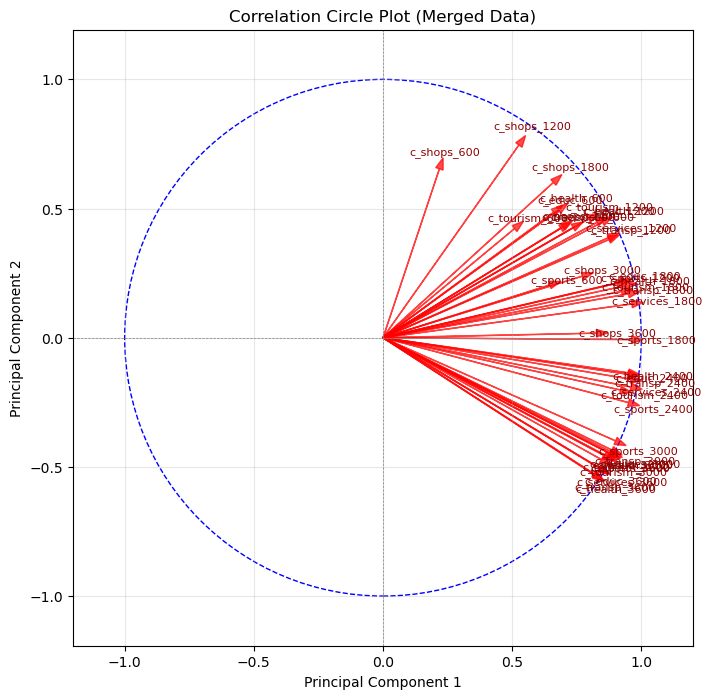

In [7]:
# Normalize the PCA loadings to ensure they fit within the unit circle (factor map)
loadings = car_pca.components_.T * np.sqrt(car_pca.explained_variance_)
features = car_merged.columns[1:]

plt.figure(figsize=(8, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Unit circle
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1)
plt.gca().add_artist(circle)

# Variable contributions (scaled to the circle)
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              color='red', alpha=0.7, head_width=0.03)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, feature, 
             fontsize=8, color='darkred', ha='center', va='center')

# Formatting
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Correlation Circle Plot (Merged Data)")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.grid(alpha=0.3)
plt.show()


In [8]:
# Prepare the data for spatial visualization by adding back coordinates
pca_results = pd.DataFrame(car_pcs, columns = [f'PC{i+1}' for i in range(car_pcs.shape[1])])
pca_results['y'] = car_merged['isochrone_file'].str[15:22]  # Extract 14th to 21st characters
pca_results['x'] = car_merged['isochrone_file'].str[23:30]  # Extract 22nd to 29th characters
geometry = [Point(xy) for xy in zip(pca_results['x'], pca_results['y'])]
pca_results['geometry']= geometry

In [9]:
gdf = gpd.GeoDataFrame(pca_results, geometry=geometry)
gdf.set_crs("EPSG:3035", inplace=True)

,PC1,PC2,y,x,geometry
0,-5.506328,-0.390688,2772600,3736600,POINT (3736600 2772600)
1,-5.423460,-0.447525,2772600,3736800,POINT (3736800 2772600)
2,-5.243098,-0.449665,2772600,3737000,POINT (3737000 2772600)
3,-4.944894,-0.418071,2772600,3737200,POINT (3737200 2772600)
4,-5.083674,-0.442338,2772600,3737400,POINT (3737400 2772600)
...,...,...,...,...,...
5528,-1.097334,-3.178631,2796000,3709000,POINT (3709000 2796000)
5529,-1.664505,-2.916249,2796000,3709200,POINT (3709200 2796000)
5530,-3.097654,-2.528326,2796000,3709600,POINT (3709600 2796000)
5531,-4.796084,-1.727383,2796200,3702600,POINT (3702600 2796200)


In [ ]:
gdf.explore()

In [ ]:
# Export to a shapefile
gdf.to_file("C:/Users/kbons/accessibility/project_report/metrics/car_metrics3.shp", driver="ESRI Shapefile")

print("Shapefile has been created successfully.")

In [ ]:
car_merged.to_csv("C:/Users/kbons/accessibility/project_report/car_merged2.csv", index = False, sep =',')

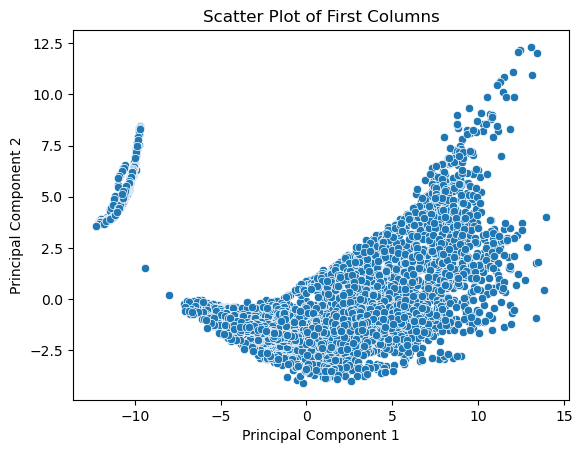

In [10]:
# Plot using seaborn
sns.scatterplot(data=gdf, x=gdf.iloc[:,0], y=gdf.iloc[:,1])

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Columns')

# Show the plot
plt.show()


C:\Users\kbons\AppData\Local\Temp\ipykernel_6624\1370673777.py:11: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroids[:, 0], centroids[:, 1], edgecolors='red', marker='x', s=200, label='Centroids')


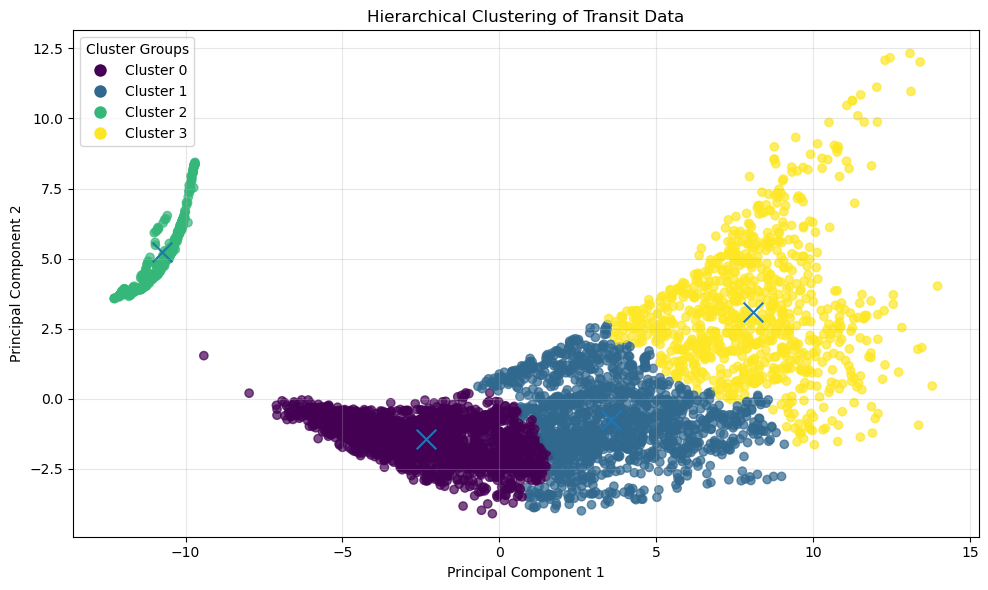

In [16]:
# Perform Hierarchical Clustering
clustering = AgglomerativeClustering(n_clusters=4)
labels = clustering.fit_predict(car_pcs)

# Calculate centroids for each cluster
centroids = np.array([car_pcs[labels == i].mean(axis=0) for i in range(4)])

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(car_pcs[:, 0], car_pcs[:, 1], c=labels, cmap='viridis', alpha=0.7, label="Data Points")
plt.scatter(centroids[:, 0], centroids[:, 1], edgecolors='red', marker='x', s=200, label='Centroids')

# Optionally annotate points (uncomment if labels are needed)
# point_labels = transit_merged['isochrone_file'].values
# for i, txt in enumerate(point_labels):
#     plt.annotate(txt, (transit_pcs[i, 0], transit_pcs[i, 1]), fontsize=8)

# Title and formatting
plt.title("Hierarchical Clustering of Transit Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Create a custom legend for the clusters
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=scatter.cmap(scatter.norm(i)),
                          markersize=10, label=f'Cluster {i}') for i in range(4)]
plt.legend(handles=legend_elements, title="Cluster Groups")

# Show the plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
cluster_results = pd.DataFrame({
    'PC1': car_pcs[:, 0],
    'PC2': car_pcs[:, 1],
    'Cluster': labels
})

cluster_results['y'] = car_merged['isochrone_file'].str[15:22]  # Extract 14th to 21st characters
cluster_results['x'] = car_merged['isochrone_file'].str[23:30]  # Extract 22nd to 29th characters
cluster_results['geometry']= geometry


car_cluster = gpd.GeoDataFrame(cluster_results, geometry=geometry)
car_cluster.set_crs("EPSG:3035", inplace=True)


,PC1,PC2,Cluster,y,x,geometry
0,-5.506328,-0.390688,0,2772600,3736600,POINT (3736600 2772600)
1,-5.423460,-0.447525,0,2772600,3736800,POINT (3736800 2772600)
2,-5.243098,-0.449665,0,2772600,3737000,POINT (3737000 2772600)
3,-4.944894,-0.418071,0,2772600,3737200,POINT (3737200 2772600)
4,-5.083674,-0.442338,0,2772600,3737400,POINT (3737400 2772600)
...,...,...,...,...,...,...
5528,-1.097334,-3.178631,0,2796000,3709000,POINT (3709000 2796000)
5529,-1.664505,-2.916249,0,2796000,3709200,POINT (3709200 2796000)
5530,-3.097654,-2.528326,0,2796000,3709600,POINT (3709600 2796000)
5531,-4.796084,-1.727383,0,2796200,3702600,POINT (3702600 2796200)


In [ ]:
car_cluster['Cluster'].unique()

In [14]:
car_cluster['Cluster'] = car_cluster['Cluster'].replace({0:"Low", 1:"Moderate", 2:"Very Low", 3:"High"})

In [15]:
car_cluster.explore(
    column="Cluster",
    cmap= "viridis", 
    popup=["PC1", "PC2", "Cluster"]
)

In [17]:
car_cluster.to_file("C:/Users/kbons/accessibility/project_report/metrics/car_metrics4.shp", driver="ESRI Shapefile")